In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
from scipy.stats import norm

t_initial = 0
dt = 0.001
t_final = 365+dt
t_vector = np.arange(t_initial, t_final, dt).T

In [2]:
x_vector = np.zeros(len(t_vector), dtype=np.complex64)
x_vector[0] = 0.5

rng = default_rng(1) # Setting the rng seed for reproduciblity.

lam   = 1.0/10 # 1/lam is the decorrelation time
sig   = 0.9    # The standard deviation of the equilibrium distribution, which is Gaussian.
mu    = 0.5       # The mean of the equilibrium distribution.
theta = -0.002   # Controls how the phase of a complex OU process changes over time. 1/theta is the imaginary part of the decorrelation time.

for i_time in range(0, len(t_vector)-1):
    x = x_vector[i_time]
    dW = np.sqrt(dt)*(rng.normal()+1j*rng.normal())/np.sqrt(2)
    dx = (-(lam + theta*1j)*(x-mu))*dt + sig*np.sqrt(2*lam)*dW
    x_vector[i_time+1] = x + dx

data = np.real(x_vector[::int(1/dt)]) #data for PF, the real component of the simulated process


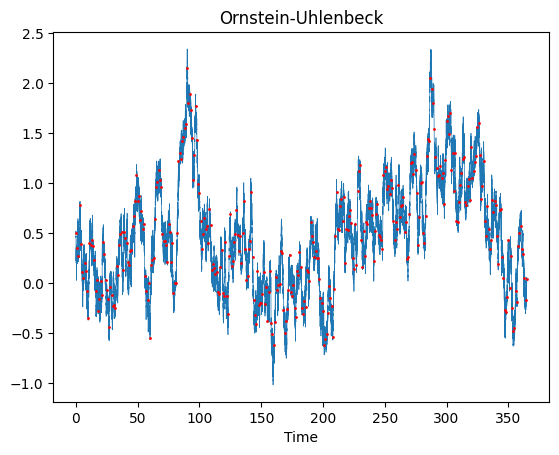

In [17]:
plt.title("Ornstein-Uhlenbeck")
plt.plot(t_vector, np.real(x_vector),lw=0.5)
plt.scatter(t_vector[::int(1/dt)],data,color = 'red', s= 1., zorder = 12)
plt.xlabel("Time")
plt.show()

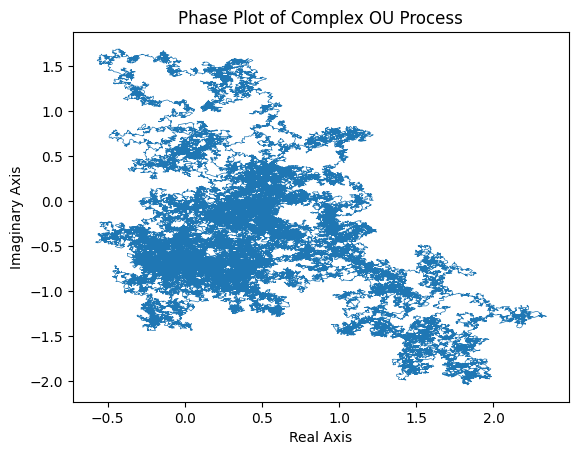

In [4]:
plt.title("Phase Plot of Complex OU Process")
plt.xlabel("Real Axis")
plt.ylabel("Imaginary Axis")
plt.plot(np.real(x_vector[:100000]), np.imag(x_vector[:100000]),lw=0.5)
plt.show()

In [5]:
'''Particle Filtering Setup'''

pf_rng = np.random.default_rng(5)

num_particles = 1000

weights = np.full((num_particles,len(data)),fill_value=1/num_particles)
particles = np.zeros((num_particles,4,len(data))) #Two states, the imaginary part and the real part. Only the real data is observed, hence this forms a HMM. Two parameters, the mean and variance of the OU process itself. 
particles[:,:,0] = pf_rng.uniform(0.,1.,size = (num_particles,4))

In [6]:
'''Particle Filtering Execution Loop'''

for t,data_point in enumerate(data):

    print(f"Iteration: {t}")

    ###Simulation/Forecast
    if(t > 0):

        particles[:,:,t] = particles[:,:,t-1]

        for _ in range(int(1/dt)):

            ###OU Process describing the distribution of the state
            dW = np.sqrt(dt)*(pf_rng.normal(loc = 0,scale = 1,size=(num_particles,)) \
            +1j*pf_rng.normal(loc = 0,scale = 1,size=(num_particles,)))/np.sqrt(2)

            dx = (-(lam + theta*1j)*((particles[:,0,t] + 1j * particles[:,1,t]) - particles[:,2,t]))*dt + particles[:,3,t]*np.sqrt(2*lam)*dW

            particles[:,0,t] = particles[:,0,t] + np.real(dx)
            particles[:,1,t] = particles[:,1,t] + np.imag(dx)

            ###Processes describing the mean and variance of the stationary distribution itself. 
            particles[:,2,t] = pf_rng.normal(particles[:,2,t-1],scale = np.sqrt(dt))
            particles[:,3,t] = pf_rng.normal(particles[:,3,t-1],scale = np.sqrt(dt))
            

    ###Weights and Resampling

    weights[:,t] = norm.pdf(x = data_point,loc = particles[:,0,t],scale = np.sqrt(0.1))
    weights[:,t] /= np.sum(weights[:,t])
    resampling_indices = pf_rng.choice(num_particles,size = (num_particles,),p=weights[:,t])

    particles[:,:,t] = particles[resampling_indices,:,t]

    

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

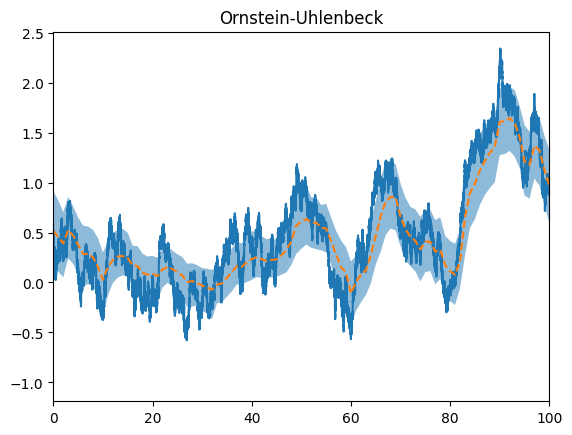

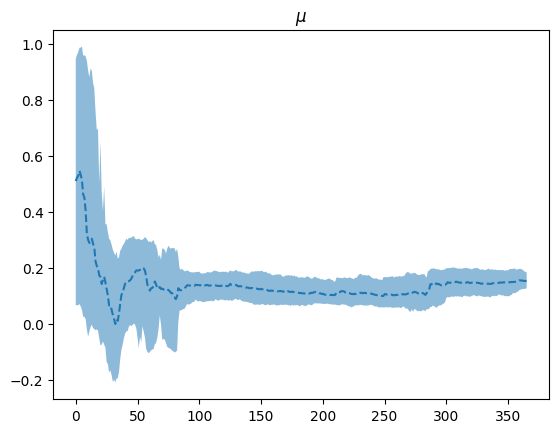

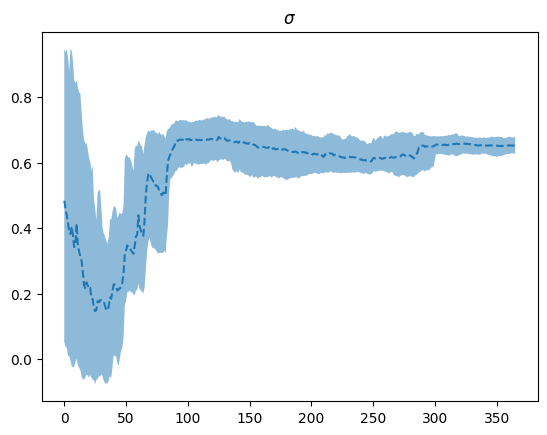

In [11]:
plt.title("Ornstein-Uhlenbeck")

plt.plot(t_vector, np.real(x_vector))

plt.plot(t_vector[::int(1/dt)],np.average(particles[:,0,:],weights=weights, axis = 0),'--')
plt.fill_between(t_vector[::int(1/dt)],np.percentile(particles[:,0,:],5,axis = 0),np.percentile(particles[:,0,:],95,axis = 0),alpha = 0.5)
plt.xlim(0, 100)
plt.show()

plt.title("$\\mu$")
plt.plot(t_vector[::int(1/dt)],np.average(particles[:,2,:],weights=weights, axis = 0),'--')
plt.fill_between(t_vector[::int(1/dt)],np.percentile(particles[:,2,:],5,axis = 0),np.percentile(particles[:,2,:],95,axis = 0),alpha = 0.5)
plt.show()

plt.title("$\\sigma$")
plt.plot(t_vector[::int(1/dt)],np.average(particles[:,3,:],weights=weights, axis = 0),'--')
plt.fill_between(t_vector[::int(1/dt)],np.percentile(particles[:,3,:],5,axis = 0),np.percentile(particles[:,3,:],95,axis = 0),alpha = 0.5)
plt.show()


In [8]:
'''Particle Filtering Setup w/ Gaussian Mixture'''

pf_rng = np.random.default_rng(5)

num_particles = 1000

weights = np.full((num_particles,len(data)),fill_value=1/num_particles)
particles = np.zeros((num_particles,4,len(data))) #Two states, the imaginary part and the real part. Only the real data is observed, hence this forms a HMM. Two parameters, the mean and variance of the OU process itself. 
particles[:,:,0] = pf_rng.uniform(0.,1.,size = (num_particles,4))

In [9]:
'''Particle Filtering Execution Loop'''

h = 0.1
a = np.sqrt(1-h**2)

for t,data_point in enumerate(data):

    print(f"Iteration: {t}")

    ###Simulation/Forecast
    if(t > 0):

        particles[:,:,t] = particles[:,:,t-1]

        for _ in range(int(1/dt)):

            ###OU Process describing the distribution of the state
            dW = np.sqrt(dt)*(pf_rng.normal(loc = 0,scale = 1,size=(num_particles,)) \
            +1j*pf_rng.normal(loc = 0,scale = 1,size=(num_particles,)))/np.sqrt(2)

            dx = (-(lam + theta*1j)*((particles[:,0,t] + 1j * particles[:,1,t]) - particles[:,2,t]))*dt + particles[:,3,t]*np.sqrt(2*lam)*dW

            particles[:,0,t] = particles[:,0,t] + np.real(dx)
            particles[:,1,t] = particles[:,1,t] + np.imag(dx)

            
        ###Jump processes describing the mean and variance of the stationary distribution itself. 
        ensemble_mean = np.average(particles[:,2:,t-1],weights=weights[:,t-1],axis = 0)
        ensemble_covariance = np.cov(particles[:,2:,t-1].T,aweights=weights[:,t-1])

        for p in range(num_particles):
            particles[p,2:,t] = pf_rng.multivariate_normal(a * particles[p,2:,t-1] + (1 - a) * ensemble_mean,(h**2) * ensemble_covariance)

        # particles[:,2,t] = pf_rng.normal(particles[:,2,t-1],scale = np.sqrt(dt))
        # particles[:,3,t] = pf_rng.normal(particles[:,3,t-1],scale = np.sqrt(dt))
            

    ###Weights and Resampling

    weights[:,t] = norm.pdf(x = data_point,loc = particles[:,0,t],scale = np.sqrt(0.1))
    weights[:,t] /= np.sum(weights[:,t])
    resampling_indices = pf_rng.choice(num_particles,size = (num_particles,),p=weights[:,t])

    particles[:,:,t] = particles[resampling_indices,:,t]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

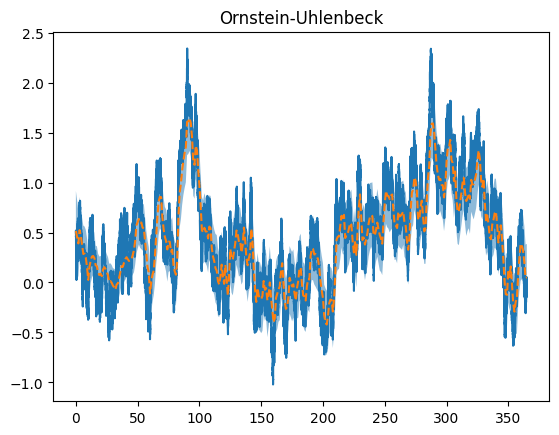

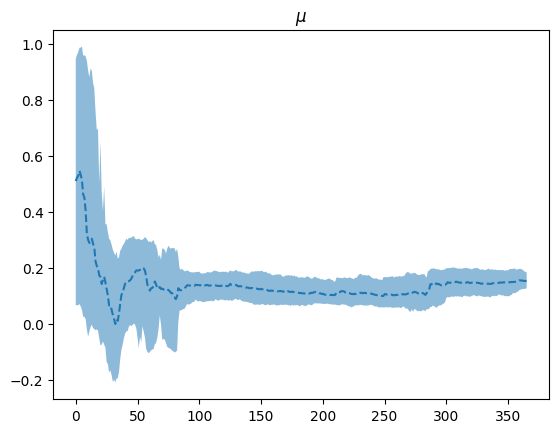

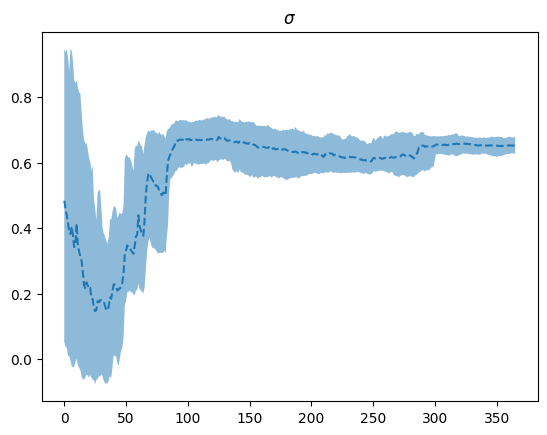

In [12]:
plt.title("Ornstein-Uhlenbeck")

plt.plot(t_vector, np.real(x_vector))

plt.plot(t_vector[::int(1/dt)],np.average(particles[:,0,:],weights=weights, axis = 0),'--')
plt.fill_between(t_vector[::int(1/dt)],np.percentile(particles[:,0,:],5,axis = 0),np.percentile(particles[:,0,:],95,axis = 0),alpha = 0.5)
plt.show()

plt.title("$\\mu$")
plt.plot(t_vector[::int(1/dt)],np.average(particles[:,2,:],weights=weights, axis = 0),'--')
plt.fill_between(t_vector[::int(1/dt)],np.percentile(particles[:,2,:],5,axis = 0),np.percentile(particles[:,2,:],95,axis = 0),alpha = 0.5)
plt.show()

plt.title("$\\sigma$")
plt.plot(t_vector[::int(1/dt)],np.average(particles[:,3,:],weights=weights, axis = 0),'--')
plt.fill_between(t_vector[::int(1/dt)],np.percentile(particles[:,3,:],5,axis = 0),np.percentile(particles[:,3,:],95,axis = 0),alpha = 0.5)
plt.show()